In [1]:
"""
updated 2019-08-09 
written by Minhae Kwon
Multinomial logistic regression for "Decoding" process with manually coded RBF
ref: https://chrisalbon.com/machine_learning/naive_bayes/multinomial_logistic_regression/


- `decoding`: Find policy that returns action from neural belief and location.
    - input:
        - if you use POMDP data (for now): `pomdp_decoding_data.csv` which includes belief and location
        - ideally, `nb_df.csv` (estimated neural belief - obtained from `encoding_v3.ipynb`) and 
        `neural_decoding_data` which includes behavior belief and location.    
    - output: `decoding_a_results_df.csv` (estimated action)
    - method: multinomial logistic regression
    - there are three versions in codes 
        - `decoding_woRBF.ipynb`: no RBF is used. Iris data is used to test the code
        - `decoding_KRR.ipynb`: RBF is used using sklearn built-in function: Kernel Ridge Regression (kernel ='rbf'). 
        This is linear regression not logistic regression Since sklearn does have multinomial logistic regression with kernel. 
        - `decoding_manualRBF.ipynb`: RBF is manually coded by me. So we can customize center locations for nonlinear transform. 
        multinomial logistic regression is used the same as `decoding_woRBF.ipynb`. <br />
    - `decoding_manualRBF.ipynb` performs the best, but not good enough (I guess..)

"""
from pandas import DataFrame, read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
# hyper parameters
POMDP = True # true if you use pomdp data, False if you use nueral data
TEST_SIZE = 0.2  # ratio of test data set 
N_SPLITS = 10 # "K" in K-fold cross validation 

In [3]:
if POMDP == True: 
    data = read_csv('./data/pomdp_decoding_data.csv')
else: # neural data is used
    data = read_csv('./data/neural_decoding_data.csv')

### RBF starts here

In [4]:
def RBF(X_set, centers, gamma=1):
    X_RBF_set = np.ones((X_set.shape[0], centers.shape[0])) # number of data set * number of center ponts
    for i in range(X_set.shape[0]):
        X = X_set[i] #i-th data
        X_RBF = np.exp(-1*1/gamma/2*np.linalg.norm(X-centers,2, axis = 1)**2)
        X_RBF_set[i] = X_RBF
    return X_RBF_set
    

In [5]:
nb_df_raw = data[['box1 belief', 'box2 belief']].to_numpy()#[:1000] # for time constraint, I tested only 1000 data points
a_df = data['action'].to_numpy()#[:1000]
loc_df_raw = data['location'].to_numpy()#[:1000]

center = np.linspace(0.05,1.05,11)[:10]
loc = np.array([0, 1, 2])

centers_b = []
centers_loc =[]
for i in itertools.product(center,center):
    centers_b.append(i)
for j in itertools.product(loc):
    centers_loc.append(j)
    
centers_b = np.array(centers_b)
centers_loc = np.array(centers_loc)

# nonlinear transform using RBF: belief and location are transformed individually
# gamma in here is the variance term in gaussian equation
nb_df = RBF(nb_df_raw, centers_b, gamma=100) 
loc_df = RBF(loc_df_raw, centers_loc, gamma=3)
nb_df = np.concatenate((nb_df, loc_df),axis=1)    

### K fold cross validation starts here

In [6]:
# separate train set and test set
nb_df_train, nb_df_test, a_df_train, a_df_test = train_test_split(nb_df, a_df, test_size=TEST_SIZE, random_state = 1)

In [7]:
X = nb_df_train
y = a_df_train

### K-fold validation starts here

In [8]:
# now we use only train data 
# why use StratifiedKFold?: The folds are made by preserving the percentage of samples for each class
k_fold = StratifiedKFold(n_splits=N_SPLITS) # seperate train data and validation data

In [9]:
# Standarize features
scaler = StandardScaler() # standarzation of data enhances the performance of logistic regression 
# Create multinomial logistic regression object
regr = LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg', n_jobs = -1)
# n_jobs = -1 make all cpu cores in your machine work
# your can also try slover ='lbfgs', but I don't see the big difference.

In [10]:
for train_index, val_index in k_fold.split(X, y):
    x_train_kf, x_val_kf = X[train_index], X[val_index]
    y_train_kf, y_val_kf = y[train_index], y[val_index]
    x_train_kf_std = scaler.fit_transform(x_train_kf)
    regr = regr.fit(x_train_kf_std, y_train_kf.ravel()) # fit the model
    
    # validation
    x_val_kf_std = scaler.fit_transform(x_val_kf)
    a_val = regr.predict(x_val_kf_std) # predict based on current model -> use validation data for evaluation
    
    #View predicted probabilities
    #prob = regr.predict_proba(x_val_kf_std)
    #print('prob:', regr.predict_proba(x_val_kf_std))
    
    #print('score', regr.score(x_val_kf_std, a_val))
    print('score', r2_score(y_val_kf, a_val, multioutput='uniform_average'))# get r2 score   

score 0.29563520050922343
score 0.28205174051583737
score 0.2766107278284342
score 0.27544639337391663
score 0.2759111487341642
score 0.2837455962354818
score 0.2919120118512618
score 0.2810898513197808
score 0.3281852696631935
score 0.28065126080918656


### print out model parameters

In [11]:
print('coef_:', regr.coef_)
print('intercept_', regr.intercept_)

coef_: [[-4.28032698e-01 -3.71320418e-01 -2.93832066e-01 -1.93482826e-01
  -7.41765746e-02  5.26121515e-02  1.72225674e-01  2.74226595e-01
   3.55498804e-01  4.18064267e-01 -3.61329469e-01 -3.21246227e-01
  -2.61106097e-01 -1.75494126e-01 -6.56507178e-02  5.49052348e-02
   1.66075536e-01  2.55100260e-01  3.20847513e-01  3.68098956e-01
  -2.76120758e-01 -2.52738670e-01 -2.12961093e-01 -1.48049954e-01
  -5.38821061e-02  5.55270254e-02  1.52563140e-01  2.22724899e-01
   2.69194662e-01  2.99915816e-01 -1.71572579e-01 -1.61935213e-01
  -1.42272261e-01 -1.03540535e-01 -3.55510076e-02  5.18013608e-02
   1.24086513e-01  1.68401423e-01  1.93877519e-01  2.09506073e-01
  -5.20191709e-02 -5.09990650e-02 -4.63613384e-02 -3.37526082e-02
  -5.29801604e-03  3.66020955e-02  6.74233471e-02  8.26929350e-02
   9.08390234e-02  9.62818738e-02  7.20588985e-02  6.75324861e-02
   6.17083777e-02  5.23188121e-02  3.34030793e-02  2.16207980e-03
  -2.16627246e-02 -3.11286819e-02 -3.35792480e-02 -3.31512844e-02
   

In [12]:
print('true number of iterations:', regr.n_iter_)

true number of iterations: [31]


### evaluate model with test data

In [13]:
### evaluate model with test data
nb_df_test_std = scaler.fit_transform(nb_df_test)
a_dec_test = regr.predict(nb_df_test_std)
#prob = regr.predict_proba(x_val_kf_std)

In [14]:
decoding_accuracy = sum(a_df_test == a_dec_test)/a_df_test.shape[0] # true == estimate

print('decoding_accuracy[%]:', decoding_accuracy*100)
print('R^2 score', r2_score(a_df_test, a_dec_test, multioutput='uniform_average'))

decoding_accuracy[%]: 67.99
R^2 score 0.30295284332607697


Text(0.5, 1.0, 'Decoding (test data)')

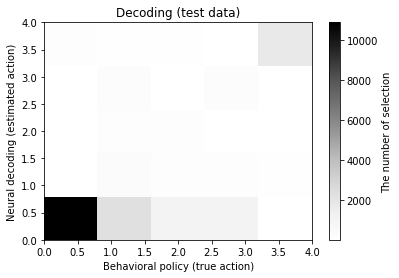

In [15]:
# plot: compare raw data vs prediction
#plt.scatter(a_df_test, a_dec_test, s=0.005, c='blue', marker='o')
plt.hist2d(a_df_test, a_dec_test, bins=(5, 5), cmap=plt.cm.Greys)
cbar = plt.colorbar()
cbar.set_label('The number of selection')
plt.xlabel('Behavioral policy (true action)') 
plt.ylabel('Neural decoding (estimated action)')
plt.title('Decoding (test data)')

[11256  3451  1656  1658  1979]


Text(0.5, 1.0, 'histogram of selected true action (true)')

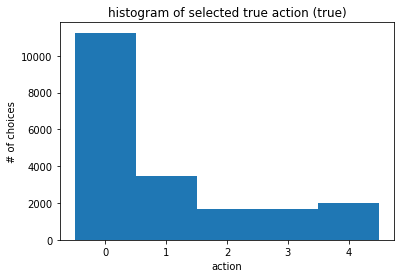

In [16]:
true_hist, _ =np.histogram(a_df_test, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
print(true_hist)

plt.hist(a_df_test, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
plt.xlabel('action')
plt.ylabel('# of choices')
plt.title('histogram of selected true action (true)')

[15349  1062   567   733  2289]


Text(0.5, 1.0, 'histogram of predicted action')

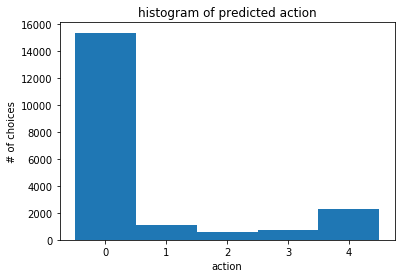

In [17]:
predicted_hist, _ =np.histogram(a_dec_test, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
print(predicted_hist)

plt.hist(a_dec_test, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
plt.xlabel('action')
plt.ylabel('# of choices')
plt.title('histogram of predicted action')

In [18]:
xedges = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
yedges = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
H, xedges, yedges = np.histogram2d(a_df_test, a_dec_test, bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.
print(H)
print(np.sum(H,axis=0))

[[1.0871e+04 2.3150e+03 1.0780e+03 1.0840e+03 1.0000e+00]
 [8.2000e+01 4.2500e+02 2.3000e+02 1.8200e+02 1.4300e+02]
 [4.6000e+01 2.4900e+02 2.3500e+02 1.1000e+01 2.6000e+01]
 [6.1000e+01 3.2200e+02 1.6000e+01 2.9600e+02 3.8000e+01]
 [1.9600e+02 1.4000e+02 9.7000e+01 8.5000e+01 1.7710e+03]]
[11256.  3451.  1656.  1658.  1979.]


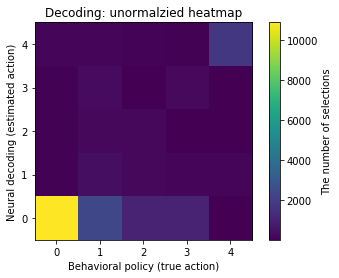

In [19]:
# this is the same plot with the above black and white figure
plt.imshow(H, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
cbar = plt.colorbar()
cbar.set_label('The number of selections')
plt.xlabel('Behavioral policy (true action)') 
plt.ylabel('Neural decoding (estimated action)')
plt.title('Decoding: unormalzied heatmap')

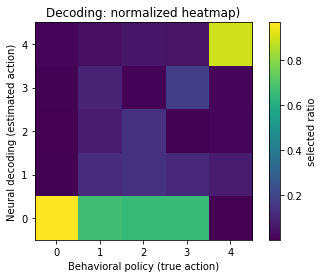

In [20]:
plt.imshow(H/np.sum(H,axis=0), interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
cbar = plt.colorbar()
cbar.set_label('selected ratio')
plt.xlabel('Behavioral policy (true action)') 
plt.ylabel('Neural decoding (estimated action)')
plt.title('Decoding: normalized heatmap)')
plt.savefig('./figures/decoding.eps', format = 'eps')